In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from Chemometrics.import_common import *
% matplotlib inline

In [2]:
df = pd.read_excel('./data/气味相图用数据.xlsx')

In [35]:
d = df.copy()
d = d.loc[:5]
d.columns  = ['id','CAS','MatchingDegree','Name','Concentration','Odt','Npt']
d['CharacterAndSmell'] = 'CharacterAndSmell'
d['HealthHazard'] = 'HealthHazard'
#d['OtherCharacter'] = 'OtherCharacter'
d['TouchLimit'] = 'TouchLimit'
d['MainFunction'] = 'MainFunction'
d['EnglishName'] ='EnglishName'
comps = d.set_index('id').to_dict(orient='records')
from Chemometrics.basic import *
from numpy.random import choice,randint
parts = pload('./data/零部件气味等级.p')
SmellLevel = ['TenBestOneWorst', 'OneBestTenWorst','SixBestOneWorst','OneBestSixWorst']

In [36]:
def CarPartCompound():
    CarPartCompound_ = {}
    CarPartCompound_["Id"] = str(randint(1000))
    CarPartCompound_["Level"] = randint(10)
    CarPartCompound_["Compounds"] = comps
    return CarPartCompound_
def CarPart():
    CurrentPart_ = {}
    CurrentPart_['Id'] = str(randint(1000))
    CurrentPart_['Name'] = parts.index[randint(10)]
    CurrentPart_['CarPartCompound'] = [CarPartCompound()]
    return CurrentPart_
def CarPartData():
    CarPartData_ = {}
    CarPartData_['CurrentPart'] = CarPart()
    CarPartData_['Children'] = [CarPartData1(),CarPartData1()]
    return CarPartData_
def CarPartData1():
    CarPartData_ = {}
    CarPartData_['CurrentPart'] = CarPart()
    CarPartData_['Children'] = []
    return CarPartData_
def car():
    car_ = {}
    car_['LogODT'] = 9
    car_['LogNPT'] = 2
    car_['SmellLevel'] = choice(SmellLevel,1)[0]
    car_['CarPartData'] = CarPartData()
    return car_

In [5]:
test_data = car()
with open('test_data_.json','w',encoding='utf-8') as f:
    json.dump(test_data,f,ensure_ascii=False)

In [37]:
TrainParams = {'TrainData':[CarPart(),CarPart()]}

In [38]:
with open('tranparams_yada.json','w',encoding='utf8') as f:
    json.dump(TrainParams,f,ensure_ascii=False)

In [25]:
TrainParams['TrainData'][0]['CarPartCompound'][0].keys()

dict_keys(['Id', 'Level', 'Compounds'])

In [26]:
TrainParams['TrainData'][0].keys()

dict_keys(['Id', 'Name', 'CarPartCompound'])

- 数据转换
  log(ODT),log(NPT),log(C)
- 拟合浓度（log)-气味等级预测直线  
    k,b
- 预测当前浓度（log)的气味等级
- 作图  
    alpha = 1
    ylim = (0,10)
    xlim =  (log_ODT.min-alpha,log_NPT.max+alpha)

In [77]:
a = df.iloc[:,[1,-1,-2,-3]]
a.columns = ['CAS','NPT','ODT','c']
a.set_index('CAS',inplace=True)
a = a.copy()
# log(0)为负无穷
a.replace(0.,np.nan,inplace=True)
log10s = np.log10(a)

- 拟合log-等级预测直线

In [79]:
levels_ = pd.Series([9,2],index=['NPT','ODT'])
delta_levels = levels_.NPT-levels_.ODT
delta_logc = log10s.NPT -log10s.ODT
k = delta_levels/delta_logc          # delta等级/delta浓度
b = levels_.NPT-log10s.NPT*k           # 等级 -  浓度*斜率 = bias

- 气味等级预测

In [81]:
levels = log10s.c*k+b

- 作图

In [86]:
# 预测直线
ys = np.vstack([np.array([9,2]*len(levels)).reshape(-1,2).T,levels])

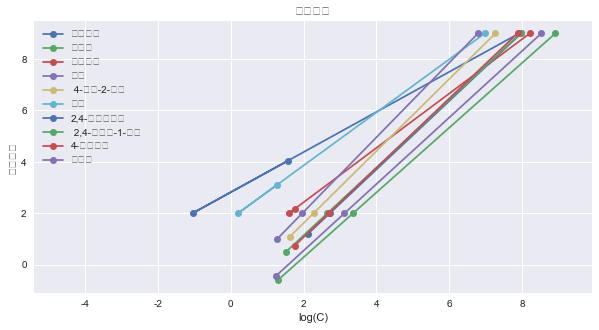

In [87]:
nlines = 10
plt.rcParams['figure.figsize'] =  [10, 5]
lines = plt.plot(log10s.values.T[:,:nlines],ys[:,:nlines],'-o')
alpha = 1
plt.xlim((log10s.ODT.min()-alpha, log10s.NPT.max()+alpha))
# plt.ylim(0,10)
l = plt.legend(lines[:nlines],df['中文名称'][:nlines])
plt.xlabel('log(C)')
plt.ylabel('气味等级')
plt.title('气味相图')